    Jacob Knopping
    1/14/2020
    
## 18.3.1 Assignment
    
## Prompt:
    
    1. Predicting temperature
    In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    a) First, load the dataset from the weatherinszeged table from Thinkful's database.
    b) Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
    c) Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.
    
    Here are the credentials you can use to connect to the database:

    postgres_user = 'dsbc_student'
    postgres_pw = '7*.8G9QH21'
    postgres_host = '142.93.121.174'
    postgres_port = '5432'
    postgres_db = 'weatherinszeged'
    
    As in earlier assignments, be sure to close the database connection after initially pulling in your data.

## Assignment Code:

In [1]:
# import the relevant libraries:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [2]:
#load the data from the PostgreSQL database
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

#no need for an open connection (just the one query)
engine.dispose()

#view first 5 rows
weather_df.head(5)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


### Missing values and outliers

In [3]:
#humidity, windspeed, windbearing, and pressure as features

#check for null values
weather_df[["humidity", "windspeed", "windbearing", "pressure"]].isnull().sum()

humidity       0
windspeed      0
windbearing    0
pressure       0
dtype: int64

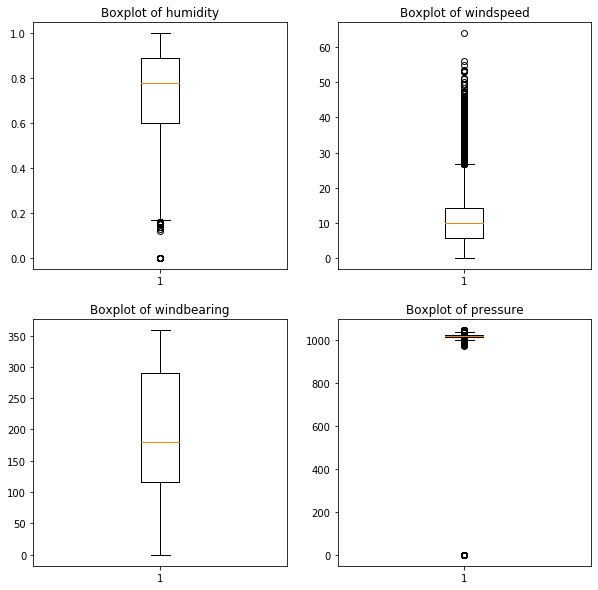

In [4]:
#check for outliers
plt.figure(figsize=(10,10))

for i, column in enumerate(weather_df[["humidity", "windspeed", "windbearing", "pressure"]]):
    plt.subplot(2,2,i+1)
    plt.boxplot(weather_df[column])
    plt.title("Boxplot of {}".format(column))

plt.show()


In [5]:
#Detecting outliers using Tukey's method(IQR range)
for column in (weather_df[["humidity", "windspeed", "windbearing", "pressure"]]):
    q75, q25 = np.percentile(weather_df[column], [75 ,25])
    iqr = q75 - q25
    #This method considers all values that are outside the threshold of 1.5 times the IQR as outliers
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers in {}: {}".format(
        column, 
        len((np.where((weather_df[column] > max_val) | (weather_df[column] < min_val))[0]))))

Number of outliers in humidity: 46
Number of outliers in windspeed: 3020
Number of outliers in windbearing: 0
Number of outliers in pressure: 4400


In [6]:
from scipy.stats.mstats import winsorize

weather_df['winsorized_humidity'] = winsorize(weather_df.humidity, (0.05, 0))
weather_df['winsorized_windspeed'] = winsorize(weather_df.windspeed, (0, 0.05))
weather_df['winsorized_pressure'] = winsorize(weather_df.pressure, (0.05, 0))

weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary', 'winsorized_humidity',
       'winsorized_windspeed', 'winsorized_pressure'],
      dtype='object')

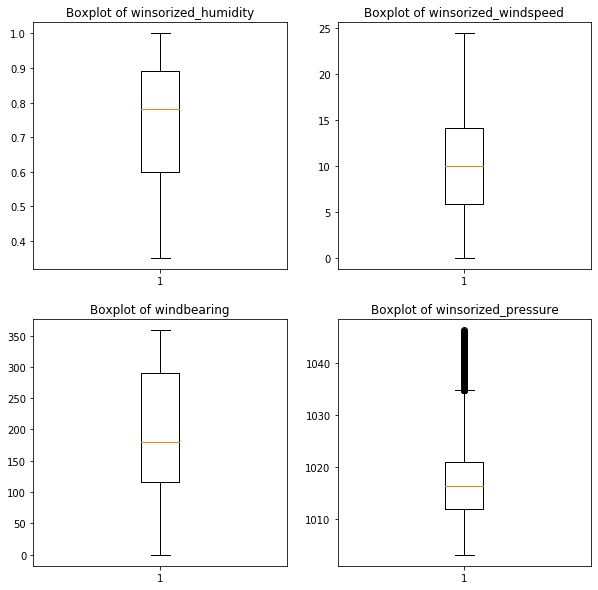

In [7]:
#check for outliers
plt.figure(figsize=(10,10))

for i, column in enumerate(weather_df[["winsorized_humidity", "winsorized_windspeed", "windbearing", "winsorized_pressure"]]):
    plt.subplot(2,2,i+1)
    plt.boxplot(weather_df[column])
    plt.title("Boxplot of {}".format(column))

plt.show()

### Regression Model

In [8]:
X = weather_df[["winsorized_humidity", "winsorized_windspeed", "windbearing", "winsorized_pressure"]]
Y = weather_df.temperature

import statsmodels.api as sm

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                 2.694e+04
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:52:55   Log-Likelihood:            -3.1835e+05
No. Observations:               96453   AIC:                         6.367e+05
Df Residuals:                   96448   BIC:                         6.368e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  480.9713      2.972    161.835      0.000     475.146     486.796
winsorized_humidity    -33.5344      0.115   -292.539      0.000     -33.759     -33.310
winsorized_windspeed    -0.3431      0.004    -95.289      0.000      -0.350      -0.336
windbearing              0.0022      0.000     11.198      0.000       0.002       0.003
winsorized_pressure     -0.4338      0.003   -149.083      0.000      -0.440      -0.428
==============================================================================
Omnibus:                     2775.626   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3024.832
Skew:                          -0.423   Prob(JB):                         0.00
Kurtosis:                       3.189   Cond. No.                     1.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Gauss-Markov Conditions

#### Assumption one: linearity of the model in its coefficients

In [9]:
#Equivalent model using scikit-learn to print coefficients
X = weather_df[["winsorized_humidity", "winsorized_windspeed", "windbearing", "winsorized_pressure"]]
Y = weather_df.temperature

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print('\nCoefficients:\n', lrm.coef_)
print('n\Intercept:\n', lrm.intercept_)


Coefficients:
 [-3.35344050e+01 -3.43054792e-01  2.21960751e-03 -4.33811933e-01]
n\Intercept:
 480.971331438866


This condition is met. The coefficients are indeed linear.

#### Assumption two: the error term should be zero on average

A constant was added to the regession model, which forces the error terms to be zero on average.

In [10]:
predictions = lrm.predict(X)
errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 3.907410442123002e-14


The average of the model's errors is essentially zero, and the condition is met.

#### Assumption three: homoscedasticity

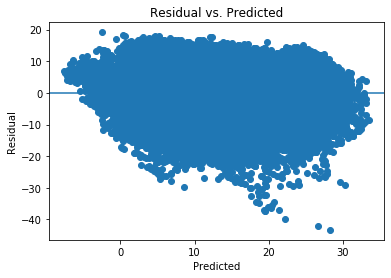

In [11]:
#Visual analysis
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Error variance seems higher for lower values of the target variable, based on the scatterplot.

In [12]:
#Statistical analysis
from scipy.stats import bartlett, levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

#Null hypothesis: errors are homoscedastic
print("Bartlett test statistic value is {0:3g} and p value is {1:3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 295.637 and p value is 2.93932e-66
Levene test statistic value is 292.101 and p value is 1.94e-65


For both the bartlett and levene tests, the p values are less than 0.05. This means the null hypothesis is rejected; the errors are heteoscedastic (condition is not met).

#### Assumption four: low multicollinearity

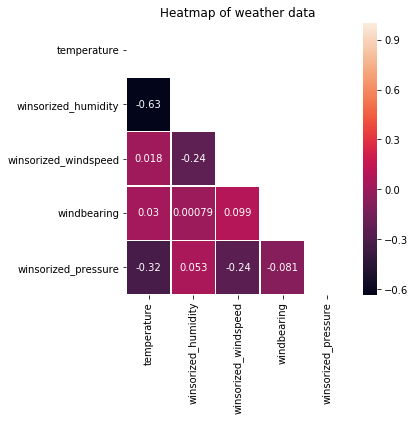

In [13]:
#Create a heatmap to show correlations
corr = weather_df[["temperature", "winsorized_humidity", "winsorized_windspeed", "windbearing", "winsorized_pressure"]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(5,5))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5)
plt.title('Heatmap of weather data')
plt.show()

Overall, individual features appear to be weakly correlated with one another. This condition is met.

#### Assumption five: error terms should be uncorrelated with one another

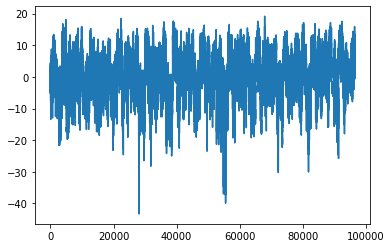

In [14]:
plt.plot(errors)
plt.show()

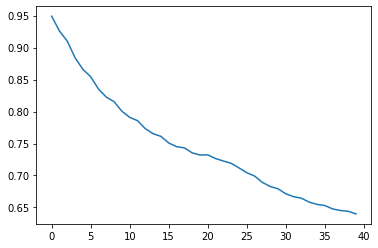

In [15]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.show()

The autocorrelation between the errors of the model is high. This condition is not met.

#### Assumption six: features shouldn't be correlated with the errors

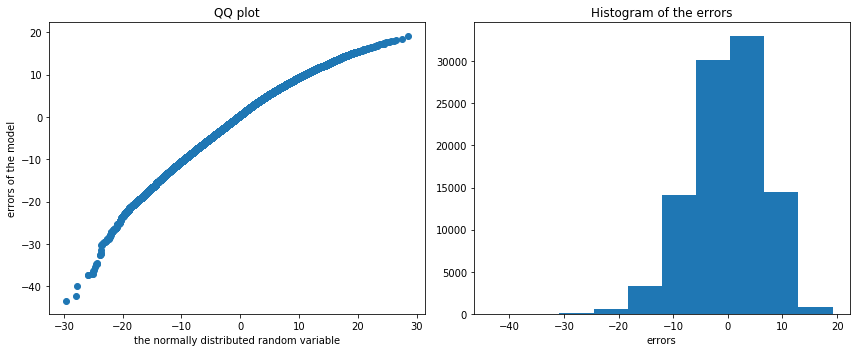

In [16]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [17]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3024.8321846804333 and p value is 0.0
Normality test statistics is 2775.625711750257 and p value is 0.0


The p-values of both tests indicate that our errors are not normally distributed, even though the QQ plot and the histogram may imply that the distribution is not very far away from normal.

This condition is not met.

#### Summary

The regression model holds some Gauss Markov assumptions to be true (linear coefficients, error term equals zero, low multicollinearity). However, some important conditions (features shouldn't be correlated with errors, homoscedasticity, error terms uncorrelated with eachother) are not met. Therefore, the regression model has limitations.